# Biomarkers for palbociclib - Workbook 2 June 2023 

## Import Data

In [1]:
import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)

# open the cache for neighbourhood calculations

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)


## Palbociclib GDSC with Goncalves et al proteomics (preprocessed & normalised)

In [2]:
# create feature and target 

import DataFunctions as utils

drug_selected = 'Palbociclib'

# create the full dataset

palbociclib_proteomic_df = utils.create_joint_dataset_from_proteome_gdsc(drug_selected, joined_sin_peptile_exclusion_matrix, gdsc2)

feature_data, label_data = utils.create_feature_and_label(palbociclib_proteomic_df)



### Computing Interactors

In [ ]:
# using STRING database to select the 1st,2nd and 3rd degree neighbours of the drug target
import pickle 
import pandas as pd

drug_targets = ['CDK4', 'CDK6']
first_degree_ids = []
first_degree_neighbours = []
second_degree_ids = []
second_degree_neighbours = []
third_degree_ids = []
third_degree_neighbours = []

for drug_target in drug_targets:
    string_id = utils.get_protein_id_by_name(drug_target, string_df_info, string_df_alias)
    if string_id is not None:
        first_interactors_string_id = utils.get_protein_interactors(string_id, string_df, score_threshold=900)
        for ii in first_interactors_string_id:
            first_degree_ids.append(ii)
            interactor_name = utils.get_protein_name_by_id(ii, goncalve_to_string_id_df, 
                                                           field_name='goncalve_protein_id',
                                                           check_field_name='string_protein_id')
            if interactor_name is not None:
                first_degree_neighbours.append(interactor_name)

print(f'First degree ids size: {len(first_degree_ids)} (With duplicate)')
first_degree_ids = list(set(first_degree_ids))
print(f'First degree ids size: {len(first_degree_ids)} (Without duplicate)')

first_degree_neighbours = list(set(first_degree_neighbours))

print(f'first degree neighbours size: {len(first_degree_neighbours)}')
print(f'first degree neighbours: {first_degree_neighbours}')
# get the second degree neighbours using first_interactors_string_id

for ii in first_degree_ids:
    second_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for sec_ii in second_interactors_string_id:
        second_degree_ids.append(sec_ii)
        interactor_name = utils.get_protein_name_by_id(sec_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            second_degree_neighbours.append(interactor_name)

print(f'second degree ids size: {len(second_degree_ids)} (With duplicate)')
second_degree_ids = list(set(second_degree_ids))
print(f'second degree ids size: {len(second_degree_ids)} (Without duplicate)')

second_degree_neighbours = list(set(second_degree_neighbours + first_degree_neighbours))
print(f'second degree neighbours size: {len(second_degree_neighbours)}')
print(f'second degree neighbours: {second_degree_neighbours}')


# get the third degree neighbours using second_interactors_string_id

for ii in second_degree_ids:
    third_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for third_ii in third_interactors_string_id:
        third_degree_ids.append(third_ii)
        interactor_name = utils.get_protein_name_by_id(third_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            third_degree_neighbours.append(interactor_name)

print(f'third degree ids size: {len(third_degree_ids)} (With duplicate)')
third_degree_ids = list(set(third_degree_ids))
print(f'third degree ids size: {len(third_degree_ids)} (Without duplicate)')

third_degree_neighbours = list(set(third_degree_neighbours + second_degree_neighbours))
print(f'third degree neighbours size: {len(third_degree_neighbours)}')
print(f'third degree neighbours: {third_degree_neighbours}')
# verify a list is unique

def verify_unique_list(l):
    return len(l) == len(set(l))

# find duplicates in the list

def find_duplicates(l):
    return list(set([x for x in l if l.count(x) > 1]))

print(f'first degree neighbours is unique: {verify_unique_list(first_degree_neighbours)}')
print(f'second degree neighbours is unique: {verify_unique_list(second_degree_neighbours)}')
print(f'third degree neighbours is unique: {verify_unique_list(third_degree_neighbours)}')

# print the duplicates in first degree neighbours

print(f'duplicates in first degree neighbours: {find_duplicates(first_degree_neighbours)}')
print(f'duplicates in second degree neighbours: {find_duplicates(second_degree_neighbours)}')
print(f'duplicates in third degree neighbours: {find_duplicates(third_degree_neighbours)}')

# save result to pickle
# filepath = data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl

n_degree_neighbours = [drug_targets, first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'wb') as f:
    pickle.dump(n_degree_neighbours, f)

### Explore statistical correlations between palbociclib IC50 and protein expression

In [ ]:
## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression

# select the top 10 features using f_regression
top_10_features = SelectKBest(f_regression, k=10).fit_transform(feature_data, label_data)

# get the feature names and the scores
feature_names = feature_data.columns
feature_scores = SelectKBest(f_regression, k=10).fit(feature_data, label_data).scores_

# create a dataframe to store the feature names and scores
feature_score_df = pd.DataFrame({'feature_name': feature_names, 'feature_score': feature_scores})

# sort the dataframe by feature scores
feature_score_df.sort_values(by=['feature_score'], ascending=False, inplace=True)

# print the top 10 features
feature_score_df



### Explore effects of feature size to performance

In [ ]:
import Visualisation as vis
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model
from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model
from sklearn.svm import SVR

# import elastic net regression model
from sklearn.linear_model import ElasticNet

# import simple mlp regression model
from sklearn.neural_network import MLPRegressor

# import xgb regression model
from xgboost import XGBRegressor

# import k nearest neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression
import shap 

## validation
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## saving and loading files
import pickle

feature_size_tested = []
for i in range(1, feature_data.shape[1] + 1, 500):
    feature_size_tested.append(i)
n_iterations = 50
cv_split_size = 0.1
rng_seed_list = []
for i in range(n_iterations):
    rng_seed_list.append(np.random.randint(0, 1000000))

data_collector = []
for f_size in feature_size_tested:
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        random_features = np.random.choice(X_train.columns, f_size, replace=False)
        X_train = X_train[random_features]
        X_test = X_test[random_features]
        # train the model
        model = ElasticNet()
        model.fit(X_train, y_train)
        # predict the test set
        y_pred = model.predict(X_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])


#### Plot the performance of the model with different feature sizes

In [ ]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
ax.set_title('Pearson correlation vs feature size using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()


In [ ]:
feature_size_tested = []
for i in range(1, 500, 10):
    feature_size_tested.append(i)
n_iterations = 50
cv_split_size = 0.1
rng_seed_list = []
for i in range(n_iterations):
    rng_seed_list.append(np.random.randint(0, 1000000))

data_collector = []
for f_size in feature_size_tested:
    print(f'feature size: {f_size}')
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        random_features = np.random.choice(X_train.columns, f_size, replace=False)
        X_train = X_train[random_features]
        X_test = X_test[random_features]
        # train the model
        model = ElasticNet()
        model.fit(X_train, y_train)
        # predict the test set
        y_pred = model.predict(X_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])

In [ ]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
ax.set_title('Pearson correlation vs feature size using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()


#### Feature size vs performance with f-regression filtering

In [ ]:
import Visualisation as vis
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model
from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model
from sklearn.svm import SVR

# import elastic net regression model
from sklearn.linear_model import ElasticNet

# import simple mlp regression model
from sklearn.neural_network import MLPRegressor

# import xgb regression model
from xgboost import XGBRegressor

# import k nearest neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression
import shap 

## validation
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## saving and loading files
import pickle

feature_size_tested = []
for i in range(1, 500, 10):
    feature_size_tested.append(i)
n_iterations = 50
cv_split_size = 0.1
rng_seed_list = []
for i in range(n_iterations):
    rng_seed_list.append(np.random.randint(0, 1000000))

data_collector = []
for f_size in feature_size_tested:
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        selector = SelectKBest(f_regression, k=f_size)
        selector.fit(X_train, y_train)
        selected_features = X_train.columns[selector.get_support()]
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]
        # train the model
        model = ElasticNet()
        model.fit(X_train, y_train)
        # predict the test set
        y_pred = model.predict(X_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # print debug info
        print(f'feature size: {f_size}, rng: {rng}, mse: {mse}, r2: {r2}, pearson_corr: {pearson_corr}')
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

stat_df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])

In [ ]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='pearson_corr', data=stat_df, ax=ax)
sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
# set the legend
ax.legend(['f-statistic selection', 'random selection'])
ax.set_title('Pearson correlation vs feature size using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()

#### Feature size vs performance with network and f-regression filtering

In [ ]:
nth_degree_neighbours = [drug_targets, first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]
max_gene_target_disance = 2 

data_collector = []
for f_size in feature_size_tested:
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        network_features = nth_degree_neighbours[max_gene_target_disance]
        # perform feature selection on the training set
        selector = SelectKBest(f_regression, k=f_size)
        selector.fit(X_train[network_features], y_train)
        # get the selected features
        selected_features = X_train[network_features].columns[selector.get_support()]
        sel_train, sel_test = X_train[selected_features], X_test[selected_features]
        # train the model
        model = ElasticNet()
        model.fit(sel_train, y_train)
        # predict the test set
        y_pred = model.predict(sel_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # print debug info
        print(f'feature size: {f_size}, rng: {rng}, mse: {mse}, r2: {r2}, pearson_corr: {pearson_corr}')
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

net_stat_df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])

In [ ]:
### plot the results

import seaborn as sns

# reindex the dataframes
plotting_df = pd.concat([df, stat_df, net_stat_df], axis=0)
plotting_df['method'] = ['random selection'] * len(df) + ['f-statistic selection'] * len(stat_df) + ['network feature selection'] * len(net_stat_df)
plotting_df.reset_index(inplace=True, drop=True)

# plot a line plot with error bars for pearson correlation
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 7))
# sns.lineplot(x='feature_size', y='pearson_corr', data=stat_df, ax=ax)
# sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
# sns.lineplot(x='feature_size', y='pearson_corr', data=net_stat_df, ax=ax)
sns.lineplot(x='feature_size', y='pearson_corr', hue='method', data=plotting_df, ax=ax)
# set the legend
# ax.legend(['f-statistic selection', 'network feature selection', 'random selection'])
ax.set_title('Pearson correlation vs feature size on palbociclib IC50 using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()

In [ ]:
plotting_df.head()

In [ ]:
# select feature size 491 with method == 'random selection'

random491 = plotting_df[(plotting_df['feature_size'] == 491) & (plotting_df['method'] == 'random selection')]

# select feature size 491 with method == 'f-statistic selection'

fstat491 = plotting_df[(plotting_df['feature_size'] == 491) & (plotting_df['method'] == 'f-statistic selection')]

# select feature size 491 with method == 'network feature selection'

net491 = plotting_df[(plotting_df['feature_size'] == 491) & (plotting_df['method'] == 'network feature selection')]

# report the mean and standard deviation of pearson correlation

print(f'random selection: mean: {random491["pearson_corr"].mean()}, std: {random491["pearson_corr"].std()}')
print(f'f-statistic selection: mean: {fstat491["pearson_corr"].mean()}, std: {fstat491["pearson_corr"].std()}')
print(f'network feature selection: mean: {net491["pearson_corr"].mean()}, std: {net491["pearson_corr"].std()}')

# using ANOVA to test if the difference between the means is significant

from scipy.stats import f_oneway

f_oneway(random491['pearson_corr'], fstat491['pearson_corr'], net491['pearson_corr'])

# report the statistic and p-value

from scipy.stats import ttest_rel 

# return the statistic and p-value

f1, p_vals1 = ttest_rel(random491['pearson_corr'], fstat491['pearson_corr'])
f2, p_vals2 = ttest_rel(random491['pearson_corr'], net491['pearson_corr'])
f3, p_vals3 = ttest_rel(fstat491['pearson_corr'], net491['pearson_corr'])

print(f'random vs f-statistic: statistic: {f1}, p-value: {p_vals1}')
print(f'random vs network: statistic: {f2}, p-value: {p_vals2}')
print(f'f-statistic vs network: statistic: {f3}, p-value: {p_vals3}')

# bonferroni correction

print(f'random vs f-statistic: statistic: {f1}, p-value: {p_vals1 * 3}')
print(f'random vs network: statistic: {f2}, p-value: {p_vals2 * 3}')
print(f'f-statistic vs network: statistic: {f3}, p-value: {p_vals3 * 3}')




### Validation Framework Implementation

#### Initial Parameters

In [ ]:
import Visualisation as vis
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model
from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model
from sklearn.svm import SVR

# import elastic net regression model
from sklearn.linear_model import ElasticNet

# import simple mlp regression model
from sklearn.neural_network import MLPRegressor

# import xgb regression model
from xgboost import XGBRegressor

# import k nearest neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression
import shap 

## validation
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## saving and loading files
import pickle


## INPUTS 
# file names 
folder_path = 'data/processed-results/workbook-jun-2023/'
input_parameter_file_path = folder_path + 'input_parameters_test.pkl'
output_file_path = folder_path + 'results_test.pkl'
experiment_name = 'test'
save_input = True
save_output = True

# hyperparameters
max_gene_target_disance = 3 # specify the level of biological relevance to drug target(s)
statistical_filter_size = 100 # can be optimized using global feature dropout testing
monte_carlo_cross_validation_size = 50 # can be automatically optimized via rank impact assessment
models_used = ['ElasticNet']
models_hyperparameters = [{}]

# extra hyperparameters
statistical_filter_threshold = 0.05 # currently not in use
cv_split_size = 0.1

# generated hyperparameters
rng_seed_lists = []
for j in range(monte_carlo_cross_validation_size):
    rng_seed_lists.append(np.random.randint(100000))

def get_model_from_string(model_name, **kwargs):
    if model_name == 'ElasticNet':
        return ElasticNet(**kwargs)
    elif model_name == 'RandomForestRegressor':
        return RandomForestRegressor(**kwargs)
    elif model_name == 'SVR':
        return SVR(**kwargs)
    elif model_name == 'MLPRegressor':
        return MLPRegressor(**kwargs)
    elif model_name == 'XGBRegressor':
        return XGBRegressor(**kwargs)
    elif model_name == 'KNeighborsRegressor':
        return KNeighborsRegressor(**kwargs)
    else:
        raise ValueError(f'{model_name} is not supported')
    
nth_degree_neighbours = [drug_targets, first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]

if save_input:
    # save initial parameters as pickle 
    with open(input_parameter_file_path, 'wb') as f:
        # dump each variable individually
        pickle.dump(max_gene_target_disance, f)
        pickle.dump(statistical_filter_size, f)
        pickle.dump(monte_carlo_cross_validation_size, f)
        pickle.dump(models_used, f)
        pickle.dump(models_hyperparameters, f)
        pickle.dump(statistical_filter_threshold, f)
        pickle.dump(cv_split_size, f)
        pickle.dump(input_parameter_file_path, f)
        pickle.dump(output_file_path, f)
        pickle.dump(rng_seed_lists, f)
        pickle.dump(nth_degree_neighbours, f)
        pickle.dump(experiment_name, f)

In [ ]:
network_features = nth_degree_neighbours[max_gene_target_disance]
X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size,
                                                    random_state=rng_seed_lists[0])

if statistical_filter_size > len(network_features):
    statistical_filter_size = len(network_features)
    print(f'WARNING: statistical_filter_size is too large, set to {statistical_filter_size}')

# perform feature selection on the training set
selector = SelectKBest(f_regression, k=statistical_filter_size)
selector.fit(X_train[network_features], y_train)

# get the selected features
selected_features = X_train[network_features].columns[selector.get_support()]

# get the feature importance
feature_importance = selector.scores_[selector.get_support()]

# DEBUG print the selected features and their importance
# print(f'selected features: {selected_features}')
# print(f'feature importance: {feature_importance}')

In [ ]:
X_train.shape

#### Feature Selection and Consensus Feature Contribution

In [3]:
from toolkit import *

tool = Toolkit(feature_data=feature_data, label_data=label_data)

tool.add_condition('network_stat',
                True,
                impute_with_network_stat_selection,
                (nth_degree_neighbours, 3, 100))

tool.add_model('ElasticNet',
            'ElasticNet', 
            {'alpha': 0.005, 'max_iter': 10000})

global_rel_tol = 0.001
global_max_iter = 250
rng_seed_lists, shap_df = tool.run_until_consensus('network_stat', rel_tol=global_rel_tol, max_iter=global_max_iter)


c:\Users\dawson\Documents\GitHub\ode-biomarker-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


current_contrib: ['P49736;MCM2_HUMAN', 'P25398;RS12_HUMAN', 'P49321;NASP_HUMAN', 'P32519;ELF1_HUMAN', 'P33993;MCM7_HUMAN']
current iteration: 2 current_tol: 0.254588, abs_diff: 1.808096, abs_prev: 7.102061, corr: 0.538681
current_contrib: ['P49736;MCM2_HUMAN', 'P25398;RS12_HUMAN', 'P49321;NASP_HUMAN', 'P32519;ELF1_HUMAN', 'P33991;MCM4_HUMAN']
current iteration: 3 current_tol: 0.138681, abs_diff: 1.103977, abs_prev: 7.960538, corr: 0.635099
current_contrib: ['P49736;MCM2_HUMAN', 'P25398;RS12_HUMAN', 'P49321;NASP_HUMAN', 'P33991;MCM4_HUMAN', 'P42768;WASP_HUMAN']
current iteration: 4 current_tol: 0.104289, abs_diff: 0.881688, abs_prev: 8.454265, corr: 0.562299
current_contrib: ['P49736;MCM2_HUMAN', 'P33991;MCM4_HUMAN', 'P25398;RS12_HUMAN', 'P49321;NASP_HUMAN', 'P63173;RL38_HUMAN']
current iteration: 5 current_tol: 0.066517, abs_diff: 0.595657, abs_prev: 8.954937, corr: 0.562802
current_contrib: ['P49736;MCM2_HUMAN', 'P49321;NASP_HUMAN', 'P33991;MCM4_HUMAN', 'P25398;RS12_HUMAN', 'P63173;RL

In [4]:
# shap_values = shap_df['shap_values'].iloc[0]
# X_test = shap_df['X_test'].iloc[0]

# print(shap_values.shape)

# # compute the mean shap value for each feature, but not absolute value

# abs_mean_shap_values = np.abs(shap_values).mean(axis=0)
# mean_shap_values = shap_values.mean(axis=0)

# # create a dataframe with the mean shap values and the feature names

# mean_shap_df = pd.DataFrame({'mean_shap_values': abs_mean_shap_values, 'feature_names': X_test.columns.tolist()})

# # sort the dataframe by mean shap value

# mean_shap_df.sort_values(by='mean_shap_values', ascending=False, inplace=True)

# # plot it as a bar chart using sns 

# # import seaborn as sns

# # sns.barplot(x='mean_shap_values', y='feature_names', data=mean_shap_df.iloc[:10])

# # loop entire dataframe and plot each row as a bar chart
# all_shap_values = []
# for i in range(shap_df.shape[0]):
#     shap_values = shap_df['shap_values'].iloc[i]
#     X_test = shap_df['X_test'].iloc[i]
#     abs_mean_shap_values = np.abs(shap_values).mean(axis=0)
#     mean_shap_values = shap_values.mean(axis=0)
#     mean_shap_df = pd.DataFrame({'mean_shap_values': abs_mean_shap_values, 'feature_names': X_test.columns.tolist()})
#     mean_shap_df.sort_values(by='mean_shap_values', ascending=False, inplace=True)
#     all_shap_values.append(mean_shap_df)

# # for all shap values, join them together
# all_shap_values_df = pd.concat(all_shap_values)

# # group by feature name and compute the mean shap value
# mean_shap_values_df = all_shap_values_df.groupby('feature_names').mean()

# # sort by mean shap value
# mean_shap_values_df.sort_values(by='mean_shap_values', ascending=False, inplace=True)

# # plot the top 10 features
# sns.barplot(x='mean_shap_values', y=mean_shap_values_df.index[:10], data=mean_shap_values_df.iloc[:10])

In [5]:
# mean_shap_values_df.head()
# altered_mean_shap_values_df = mean_shap_values_df.copy()
# # reduce the mean shap value of all features by 50%
# altered_mean_shap_values_df['mean_shap_values'] = altered_mean_shap_values_df['mean_shap_values'] * np.random.uniform(0.5, 1.0)
# altered_mean_shap_values_df.sort_values(by='mean_shap_values', ascending=True, inplace=True)

# altered_mean_shap_values_df.tail()
# # compute the difference between the original and altered mean shap values

# diff = mean_shap_values_df.copy()
# diff['mean_shap_values'] = mean_shap_values_df['mean_shap_values'] - altered_mean_shap_values_df['mean_shap_values']

# diff.head()
# abs_original = np.abs(mean_shap_values_df['mean_shap_values']).sum()

# abs_altered = np.abs(altered_mean_shap_values_df['mean_shap_values']).sum()

# print(f'abs_original: {abs_original}')

# print(f'abs_altered: {abs_altered}')

# # find the absolute difference for the sum of all features
# abs_diff = np.abs(diff['mean_shap_values']).sum()

# print(f'abs_diff: {abs_diff}, analytical difference: {abs_original - abs_altered}')


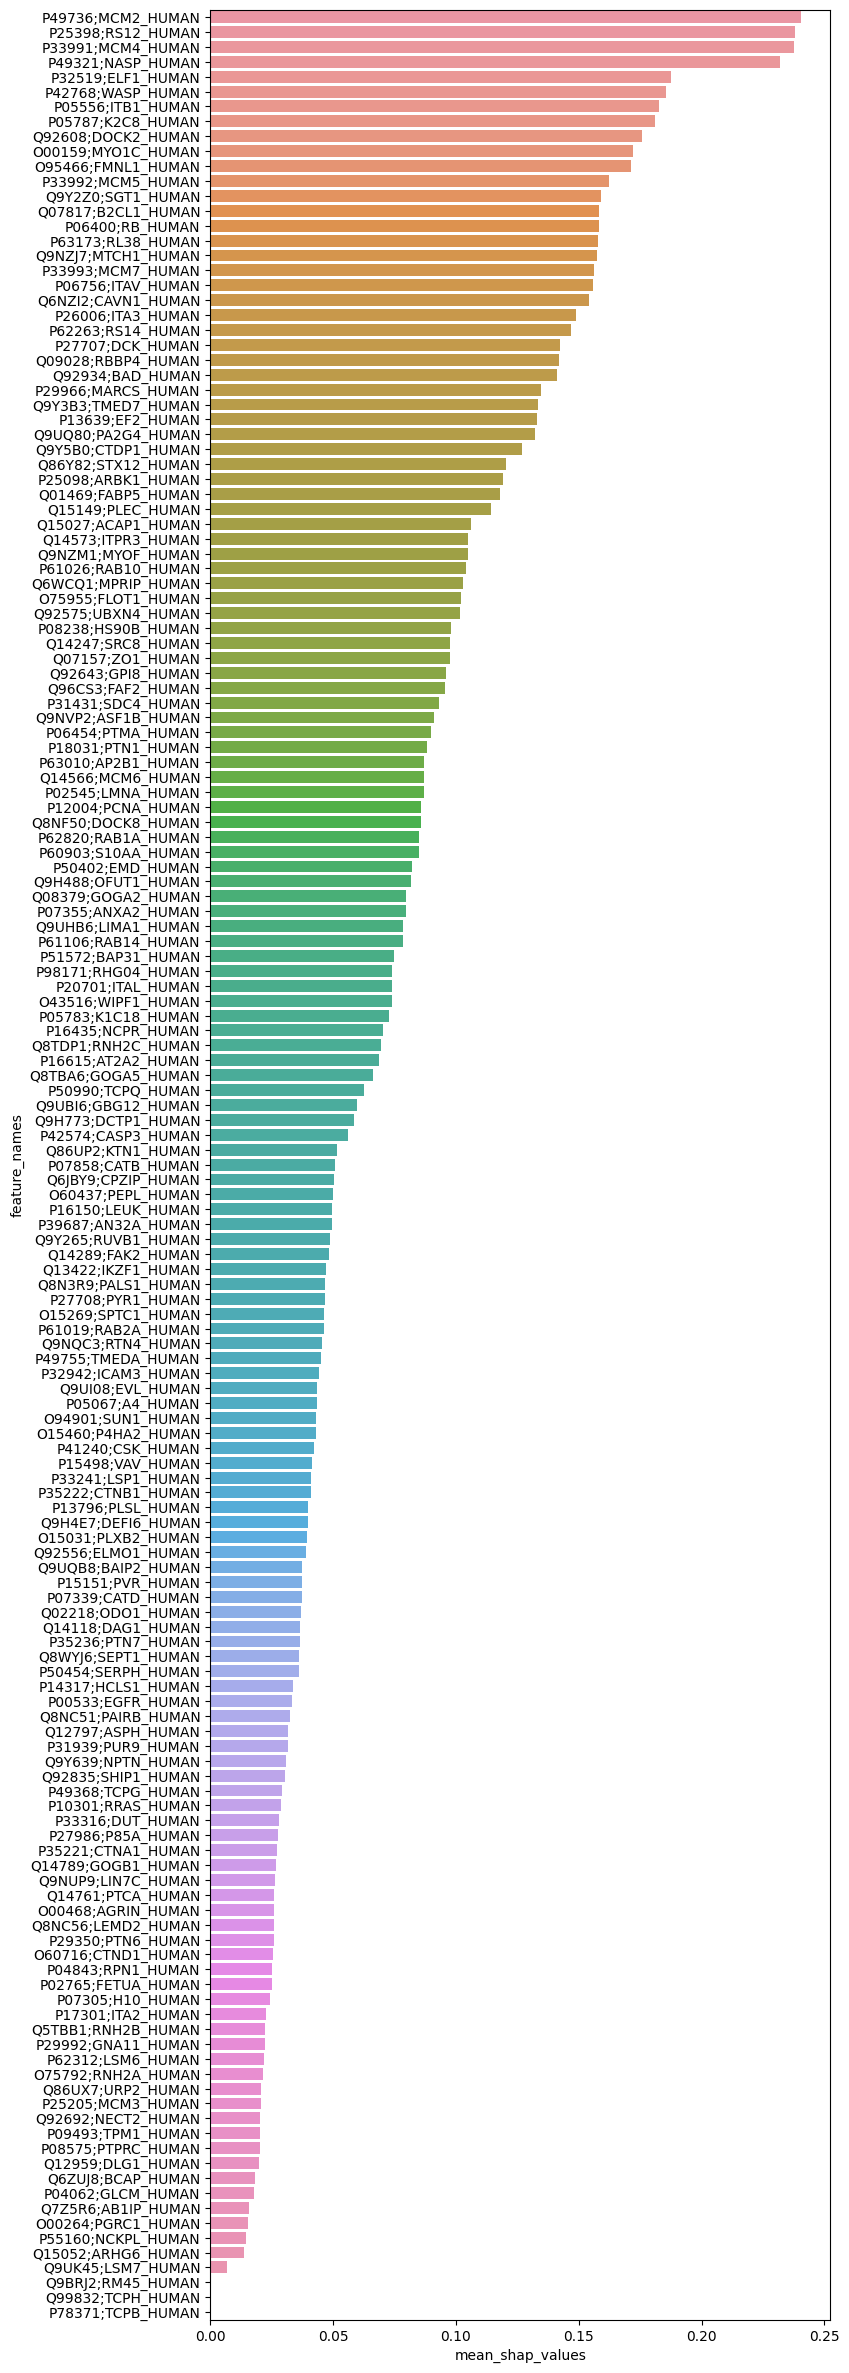

In [6]:
shap_contribs = get_mean_contribution(shap_df, 'network_stat')

import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 30))

sns.barplot(x='mean_shap_values', y=shap_contribs.index, data=shap_contribs)
plt.show()

In [7]:
# check if there are duplicated features
print(f'number of duplicated features: {len(shap_contribs.index) - len(shap_contribs.index.unique())}')

number of duplicated features: 0


#### in silico Knockout Validation 

are the features really important? Knock them out and check if the model performance decreases, compare it with a random feature knockout. If not, then what new features are contributing to the model performance?

In [8]:
# get all of the consensus features
consensus_features = [x for x in shap_contribs.index]

# top 1 feature
top_1_feature = consensus_features[0]

In [9]:
knockout_features = []
for feature in consensus_features:
    if feature != top_1_feature:
        knockout_features.append(feature)

# knockout top 10 features with the highest feature importance
knockout_features_2 = consensus_features.copy()
# remove the first 10 elements in the list
knockout_features_2 = knockout_features_2[10:]



tool.add_condition('knockout-1',
                True,
                impute_with_preset_features,
                (knockout_features,))


tool.add_condition('knockout-2',
                True,
                impute_with_preset_features,
                (knockout_features_2,))


In [10]:

rng_seed_lists_k1, shap_df_k1 = tool.run_until_consensus('knockout-1', rel_tol=global_rel_tol, max_iter=global_max_iter)


current_contrib: ['P49321;NASP_HUMAN', 'P33241;LSP1_HUMAN', 'O95466;FMNL1_HUMAN', 'O00159;MYO1C_HUMAN', 'P78371;TCPB_HUMAN']
current iteration: 2 current_tol: 0.175015, abs_diff: 1.970162, abs_prev: 11.257071, corr: 0.475165
current_contrib: ['P49321;NASP_HUMAN', 'P33241;LSP1_HUMAN', 'O00159;MYO1C_HUMAN', 'O95466;FMNL1_HUMAN', 'P78371;TCPB_HUMAN']
current iteration: 3 current_tol: 0.131753, abs_diff: 1.408192, abs_prev: 10.688113, corr: 0.592308
current_contrib: ['P49321;NASP_HUMAN', 'O00159;MYO1C_HUMAN', 'P78371;TCPB_HUMAN', 'O95466;FMNL1_HUMAN', 'P33241;LSP1_HUMAN']
current iteration: 4 current_tol: 0.099265, abs_diff: 1.016854, abs_prev: 10.243805, corr: 0.484311
current_contrib: ['P49321;NASP_HUMAN', 'O00159;MYO1C_HUMAN', 'P78371;TCPB_HUMAN', 'O95466;FMNL1_HUMAN', 'P33241;LSP1_HUMAN']
current iteration: 5 current_tol: 0.094746, abs_diff: 0.965807, abs_prev: 10.193641, corr: 0.612689
current_contrib: ['P49321;NASP_HUMAN', 'P78371;TCPB_HUMAN', 'O00159;MYO1C_HUMAN', 'O95466;FMNL1_HUMA

In [11]:

rng_seed_lists_k2, shap_df_k2 = tool.run_until_consensus('knockout-2', rel_tol=global_rel_tol, max_iter=global_max_iter)

current_contrib: ['P78371;TCPB_HUMAN', 'Q9UQ80;PA2G4_HUMAN', 'P06400;RB_HUMAN', 'P33992;MCM5_HUMAN', 'Q15149;PLEC_HUMAN']
current iteration: 2 current_tol: 0.238274, abs_diff: 2.054977, abs_prev: 8.624432, corr: 0.416297
current_contrib: ['P78371;TCPB_HUMAN', 'Q9UQ80;PA2G4_HUMAN', 'P06756;ITAV_HUMAN', 'P06400;RB_HUMAN', 'Q96CS3;FAF2_HUMAN']
current iteration: 3 current_tol: 0.141399, abs_diff: 1.308366, abs_prev: 9.253007, corr: 0.597210
current_contrib: ['P78371;TCPB_HUMAN', 'Q9UQ80;PA2G4_HUMAN', 'P06756;ITAV_HUMAN', 'Q99832;TCPH_HUMAN', 'P06400;RB_HUMAN']
current iteration: 4 current_tol: 0.099988, abs_diff: 0.950625, abs_prev: 9.507371, corr: 0.616890
current_contrib: ['P78371;TCPB_HUMAN', 'Q99832;TCPH_HUMAN', 'Q9UQ80;PA2G4_HUMAN', 'P06756;ITAV_HUMAN', 'P06400;RB_HUMAN']
current iteration: 5 current_tol: 0.073683, abs_diff: 0.704188, abs_prev: 9.556952, corr: 0.536611
current_contrib: ['P78371;TCPB_HUMAN', 'Q9UQ80;PA2G4_HUMAN', 'P06756;ITAV_HUMAN', 'Q99832;TCPH_HUMAN', 'Q6NZI2;CAVN1

In [12]:
shap_df['corr'].mean()

0.5708403093619067

In [13]:
shap_df_k1['corr'].mean()
# shap_df_k1['corr'].std()

0.5788804297555121

In [14]:
shap_df_k2['corr'].mean()


0.5653375431599889

In [15]:
knockout_mean_shap_values = get_mean_contribution(shap_df_k1, condition='knockout-1')
knockout_mean_shap_values_2 = get_mean_contribution(shap_df_k2, condition='knockout-2')

In [16]:
shap_contribs.shape

(155, 1)

In [17]:
knockout_mean_shap_values.shape

(154, 1)

In [18]:
knockout_mean_shap_values_2.shape

(145, 1)

In [25]:
mean_shap_values_1 = shap_contribs
mean_shap_values_2 = knockout_mean_shap_values

total_sum_og = get_abs_sum_for_feature_contributions(shap_contribs)
total_sum_ko = get_abs_sum_for_feature_contributions(knockout_mean_shap_values)
total_sum_ko_2 = get_abs_sum_for_feature_contributions(knockout_mean_shap_values_2)

print(f'### Total absolute sum of mean shap values: {total_sum_og}')
print(f'### Total absolute sum of mean shap values for knockout 1: {total_sum_ko}')
print(f'### Total absolute sum of mean shap values for knockout 2: {total_sum_ko_2}')

# compute the total absolute change in mean shap values by summing the absolute change for each feature
diff = get_diff_between_feature_contributions(mean_shap_values_1, mean_shap_values_2)
total_abs_change = get_abs_sum_for_feature_contributions(diff)
print(f'### Total absolute change in mean shap values: {total_abs_change}')

# compute total absolute change in mean shap values for each feature between knockout 2 and original 
diff2 = get_diff_between_feature_contributions(mean_shap_values_1, knockout_mean_shap_values_2)
abs_change_2 = get_abs_sum_for_feature_contributions(diff2)
print(f'### Total absolute change in mean shap values for knockout 2: {abs_change_2}')


from scipy.stats import ttest_rel, ttest_ind
def report_ttest_for_performance(df1, df2, condition1, condition2, verbose=True):
    if verbose:
        print(f'### Running t-test for performance between {condition1} and {condition2}')
        print(f'Mean performance of {condition1}: {df1[df1["exp_condition"]==condition1]["corr"].mean():.3f}, variance: {df1[df1["exp_condition"]==condition1]["corr"].var():.3f}')
        print(f'Mean performance of {condition2}: {df2[df2["exp_condition"]==condition2]["corr"].mean():.3f}, variance: {df2[df2["exp_condition"]==condition2]["corr"].var():.3f}')
    t_stat, p_val = ttest_ind(df1[df1['exp_condition']==condition1]['corr'], df2[df2['exp_condition']==condition2]['corr'])
    if verbose:
        print(f'### t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}')
    return t_stat, p_val

t_stat, p_val = report_ttest_for_performance(shap_df, shap_df_k1, 'network_stat', 'knockout-1')

t_stat, p_val = report_ttest_for_performance(shap_df, shap_df_k2, 'network_stat', 'knockout-2')

### Total absolute sum of mean shap values: 11.523578139619506
### Total absolute sum of mean shap values for knockout 1: 10.478209550821527
### Total absolute sum of mean shap values for knockout 2: 9.309057821103393
### Total absolute change in mean shap values: 4.2864399610414585
### Total absolute change in mean shap values for knockout 2: 3.7805668522738025
### Running t-test for performance between network_stat and knockout-1
Mean performance of network_stat: 0.571, variance: 0.007
Mean performance of knockout-1: 0.579, variance: 0.005
### t-statistic: -1.159, p-value: 0.247
### Running t-test for performance between network_stat and knockout-2
Mean performance of network_stat: 0.571, variance: 0.007
Mean performance of knockout-2: 0.565, variance: 0.006
### t-statistic: 0.765, p-value: 0.445


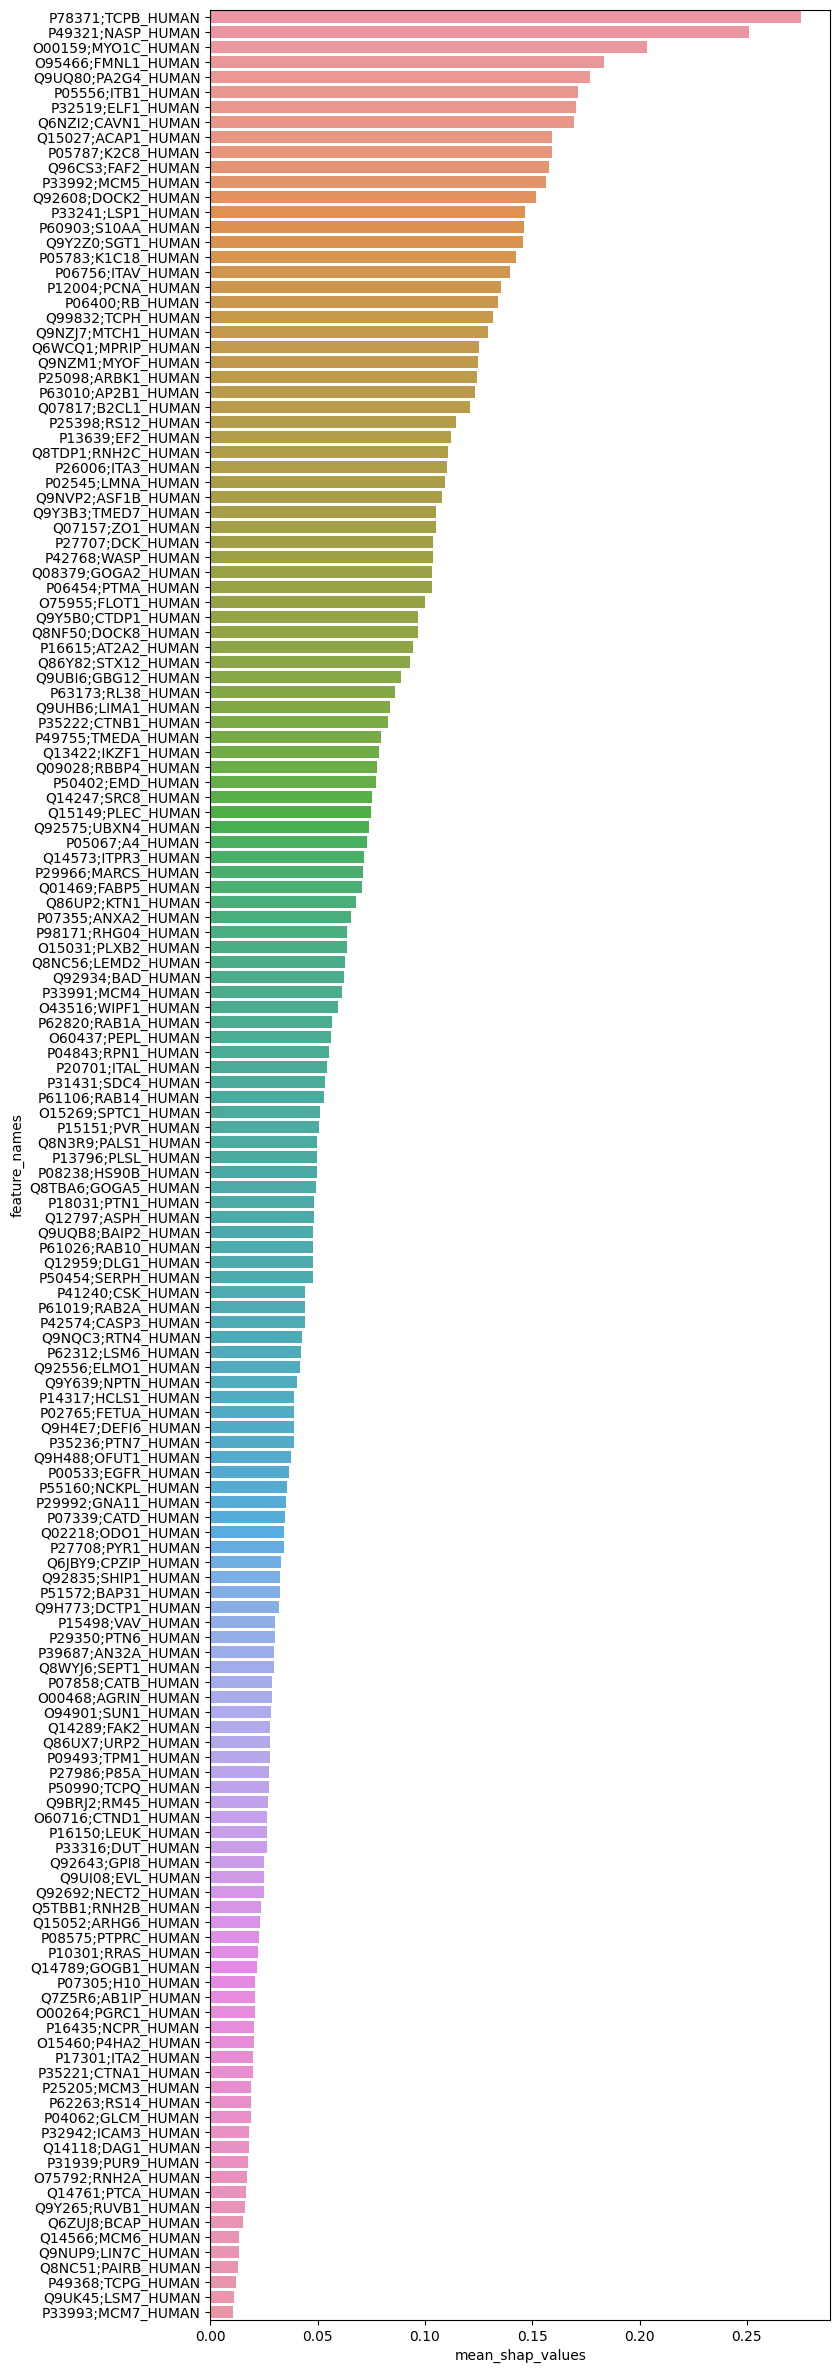

In [26]:
# plot the mean shap values

import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(8, 30))

sns.barplot(x='mean_shap_values', y=knockout_mean_shap_values.index, data=knockout_mean_shap_values)
plt.show()

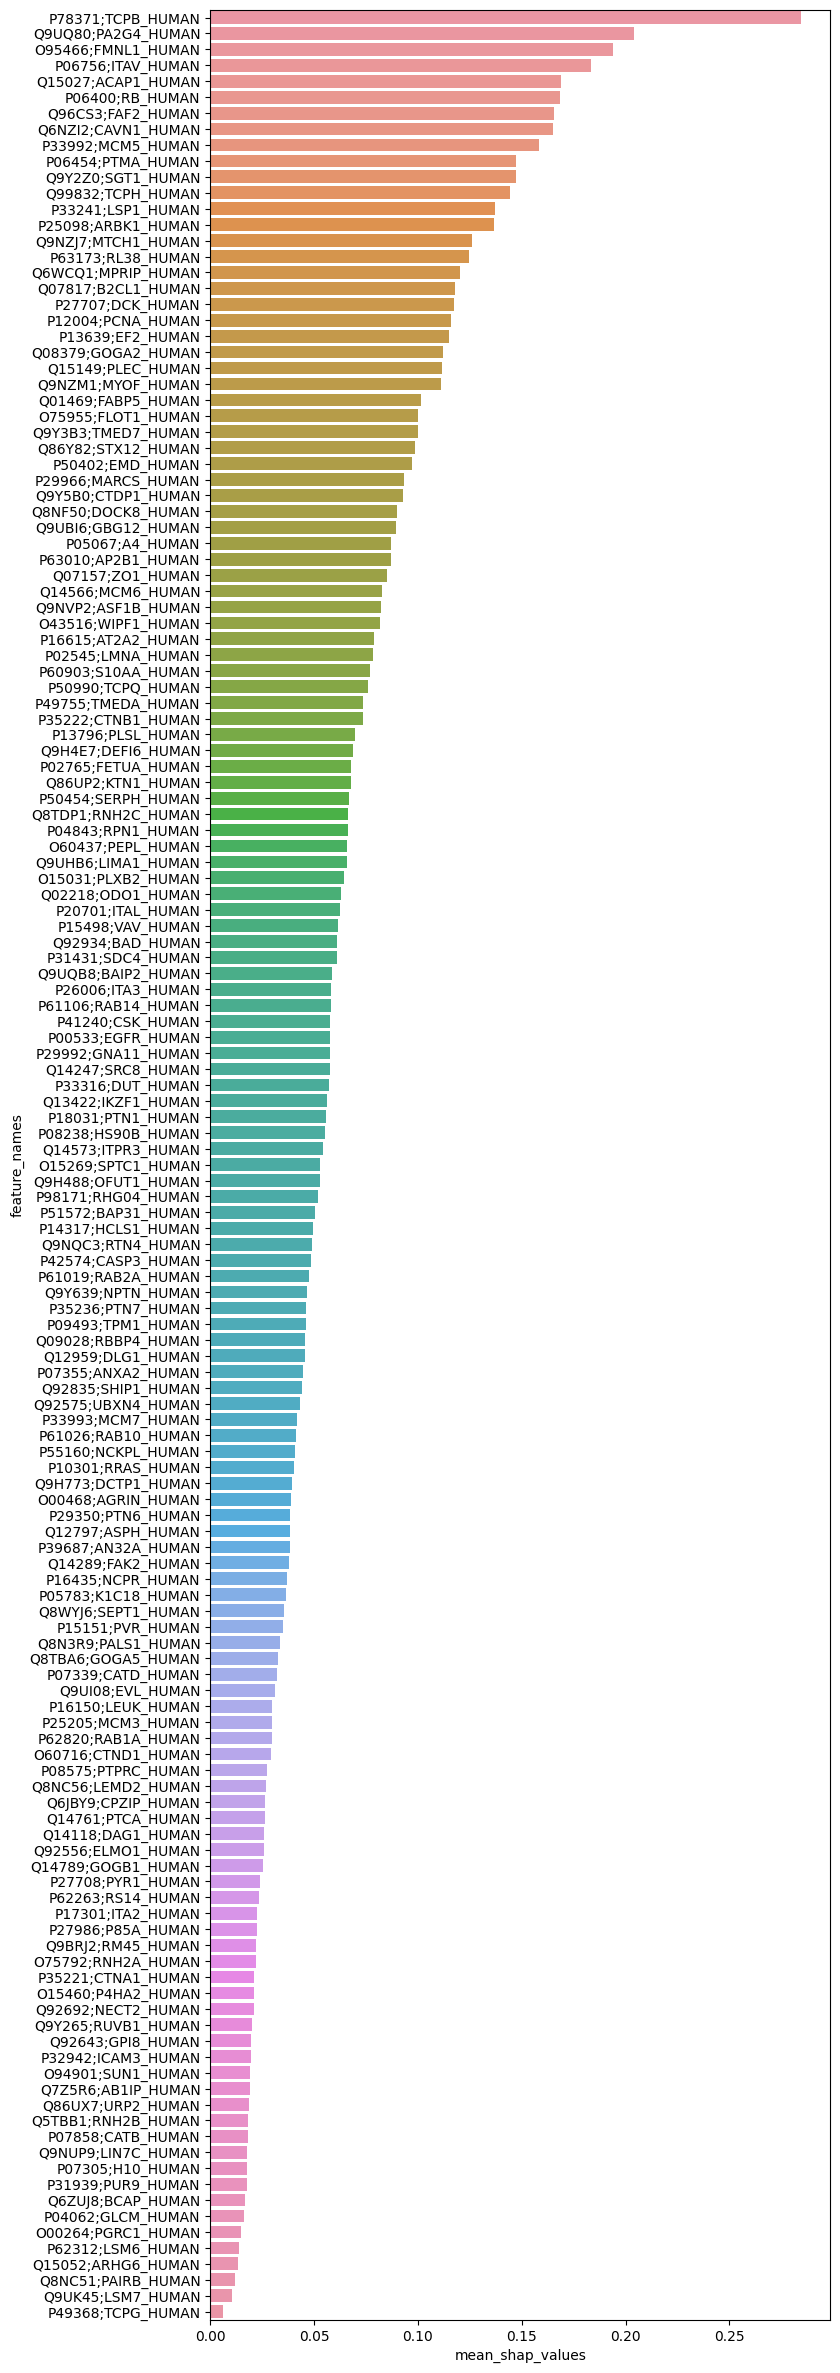

In [27]:
fig, ax = plt.subplots(figsize=(8, 30))

sns.barplot(x='mean_shap_values', y=knockout_mean_shap_values_2.index, data=knockout_mean_shap_values_2)
plt.show()

#### Calculate the difference in mean contribution of features between two mean shap values

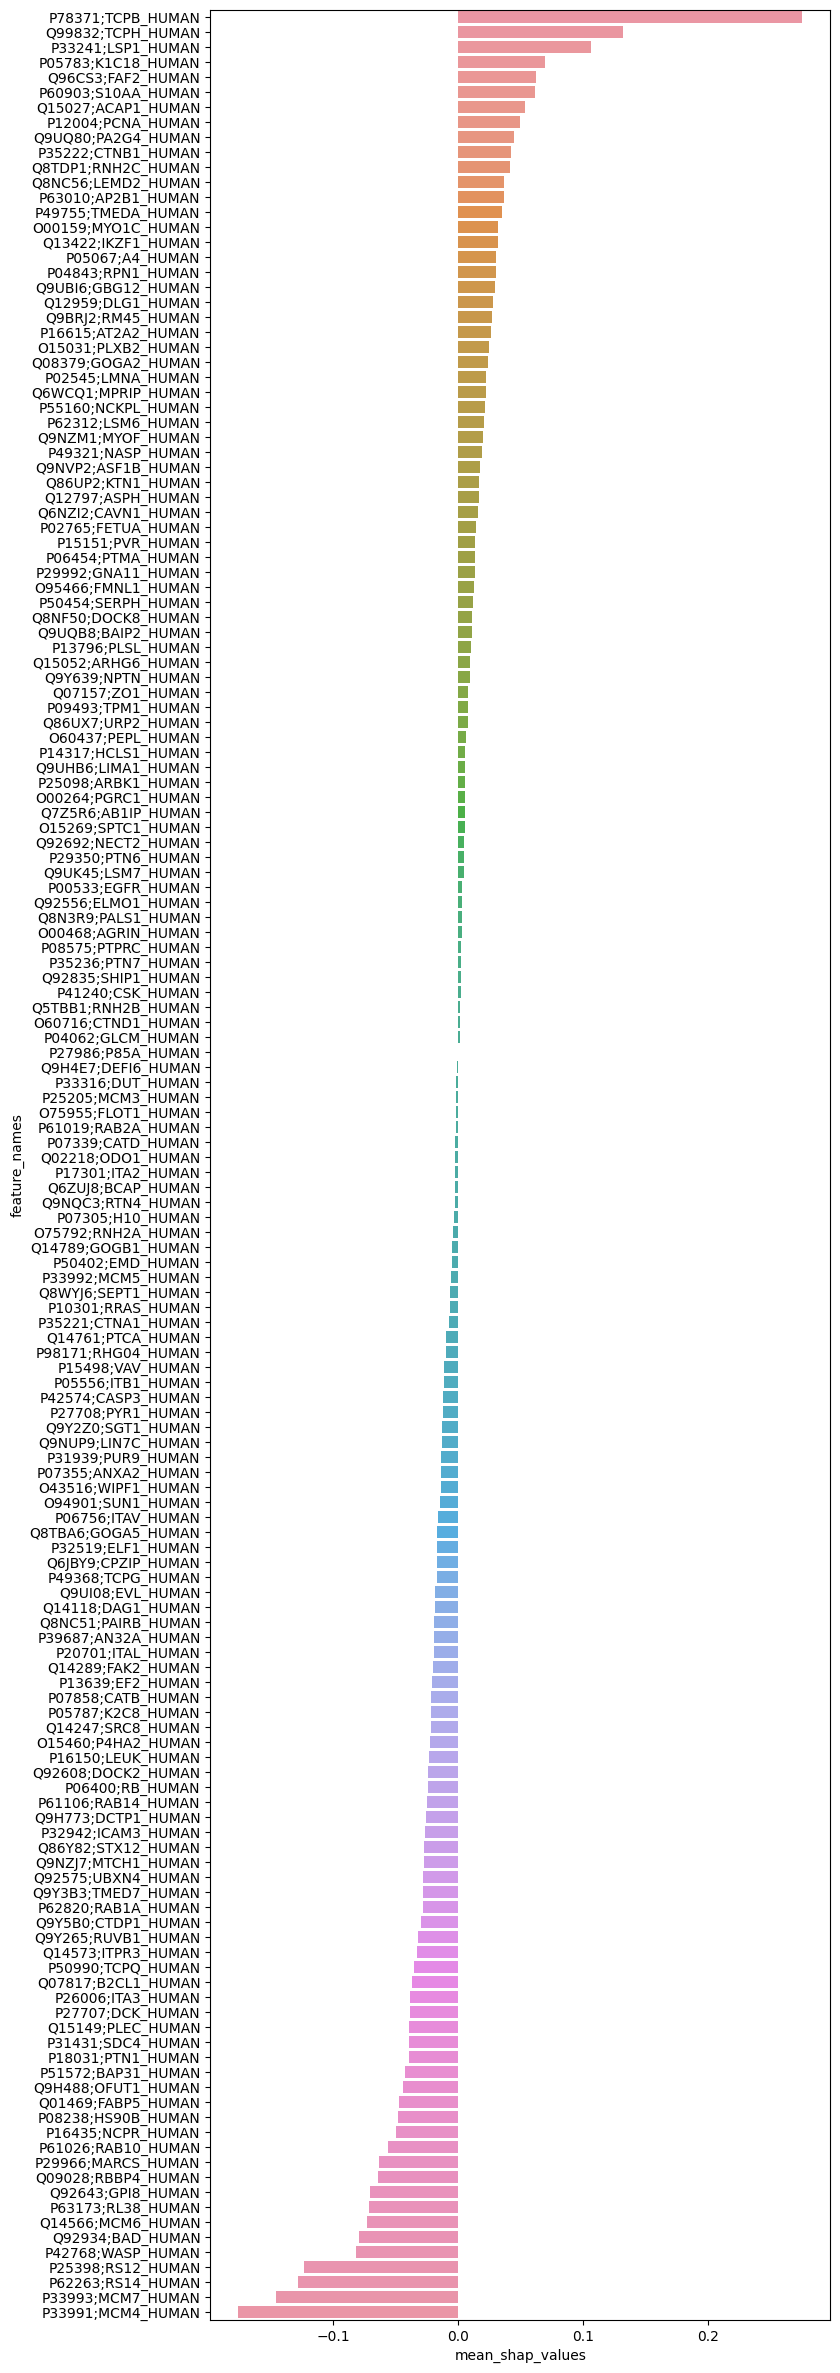

In [28]:
diff.sort_values(by='mean_shap_values', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(8, 30))

sns.barplot(x='mean_shap_values', y=diff.index, data=diff)
plt.show()


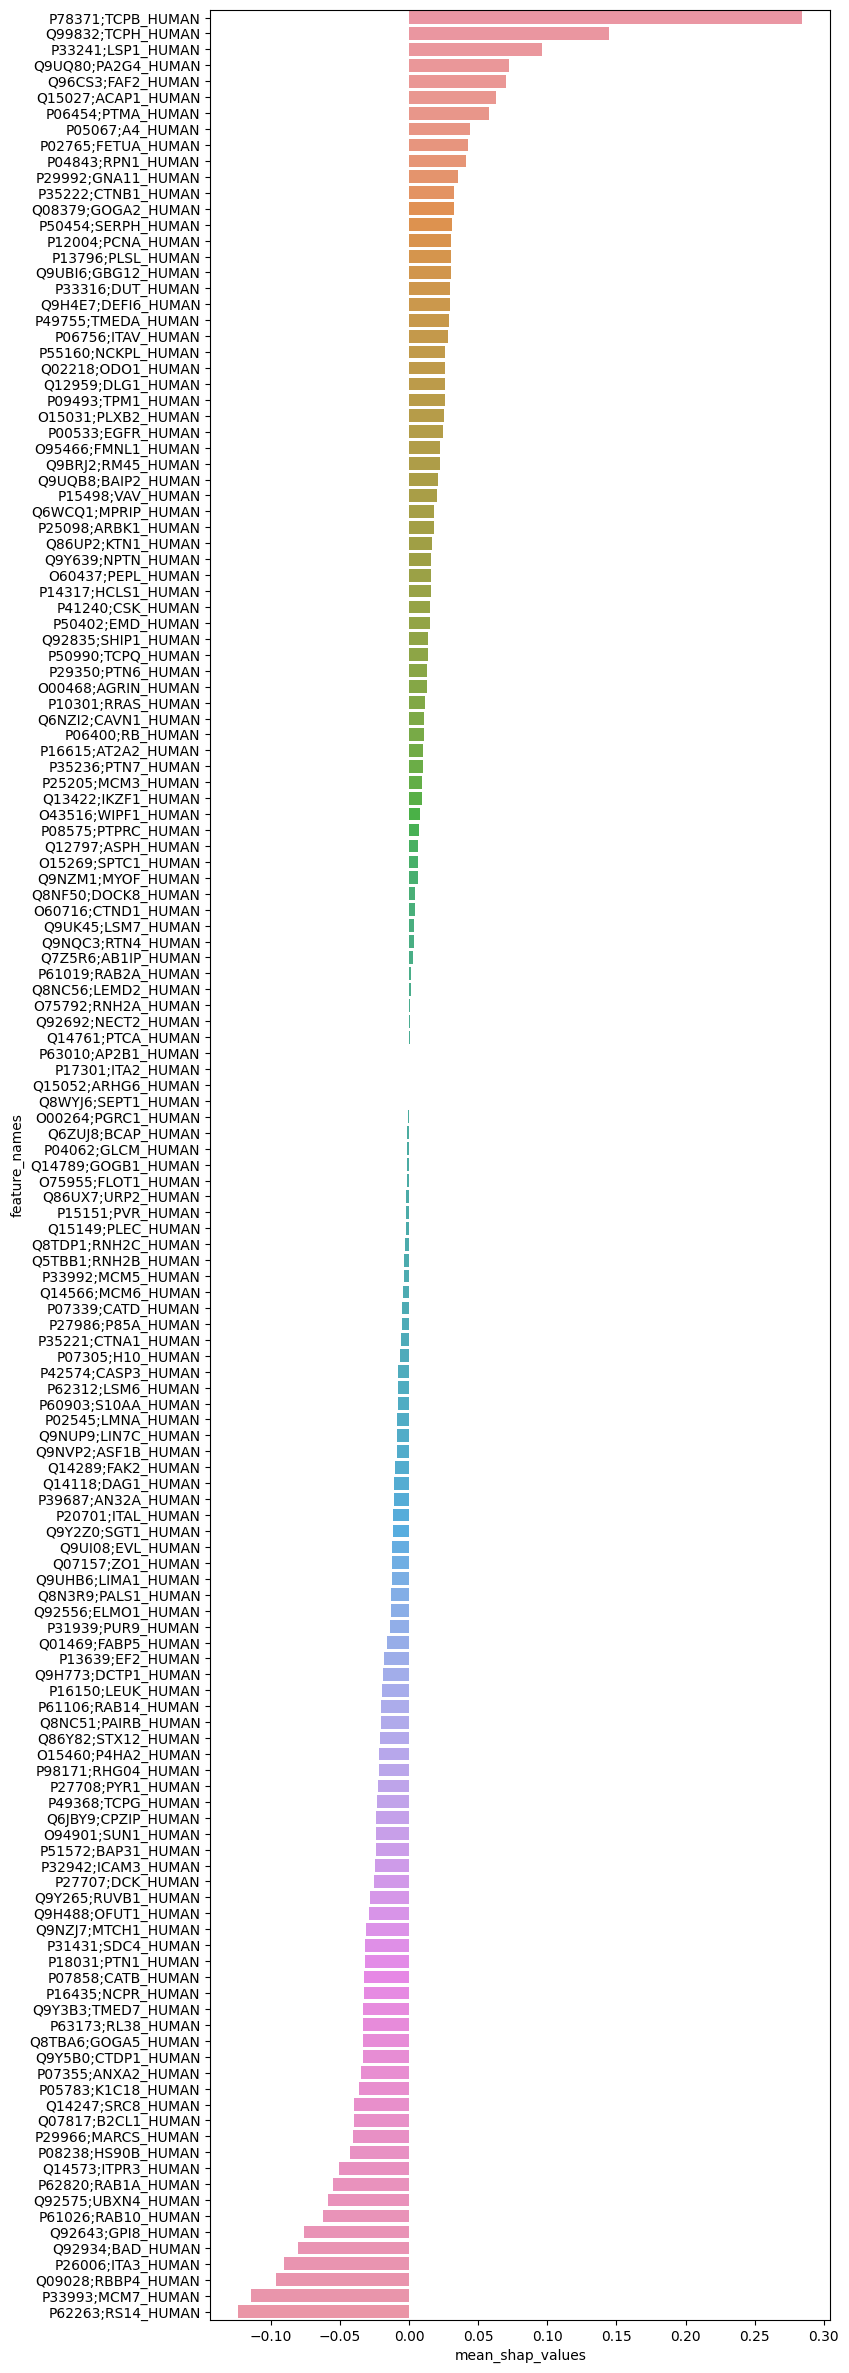

In [29]:
diff2.sort_values(by='mean_shap_values', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(8, 30))

sns.barplot(x='mean_shap_values', y=diff2.index, data=diff2)
plt.show()


conclusion: when one protein gets knocked out, another protein of statistically similar shape will take its place and contribute to the model performance.

mean absolute change in shap value between two mean shap values is highly interesting and should be explored further. Mean absolute change, in this case, represents the total perturbation effect of any n-sized feature set on the holistic feature contribution landscape. This will allow for the quantification, and visualisation for the explanation of model performance between different *in silico* experimental conditions.

model performance between different conditions can now be directly compared using pearson correlation coefficient, r2 and mean squared error.

One interesting hypothesis is that when mean absolute change in feature contribution is low between two conditions, model performance drops proportionally to the knocked out features. This can be that the model can no longer compensate for the loss of the feature by adjusting contribution of still-existing features and the model performance drops.

This feature selection approach is model-agnostic and can be applied to any model. It is scalable with increased computational power and can be used to compare model performance between different conditions. Filtering selection and in addition, even the global feature importance approaches can be substituted (e.g. lime) 

We can also select any n-feature combination, knock them out and compare the model performance with the original model performance, while similarly comparing the mean absolute change in feature contribution between the two conditions. If n is small (e.g. less than 3), we can experimentally validate the results using in vitro experiments. Specifically, once the n-feature combination is selected, we assess their correlation with LN_IC50 of the drug of interest. If a featuer correlation is *positive*, then the cell lines are resistant to drug when expression is high, *knockout* of the feature should *increase* the drug sensitivity. If a feature correlation is *negative*, then *overexpression* of the feature should *increase* the drug sensitivity.